# Token Embedding

## 1. Setup

In [1]:
import math
import faiss

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import AutoModel, AutoModelForTokenClassification

In [6]:
teacher_logits = torch.rand(32, 1000)
local_idxs = torch.argsort(-teacher_logits, dim=-1)[:, :10]

In [17]:
teacher_logits.size()

torch.Size([32, 1000])

In [12]:
local_idxs.size()

torch.Size([32, 10])

In [15]:
torch.gather(teacher_logits, 1, local_idxs)

torch.Size([32, 10])

In [16]:
teacher_logits[:, local_idxs].size()

torch.Size([32, 32, 10])

In [4]:
b = torch.tensor([[1, 2], [2, 2], [3, 100], [1, 10]])

In [2]:
a = torch.rand(4, 128)

In [5]:
a[b]

IndexError: index 100 is out of bounds for dimension 0 with size 4

## 2. Model

In [31]:
def transpose_for_scores(h, num_heads):
    hsize = h.size()
    if len(hsize) == 3:
        batch_size, seq_length, dim = h.size()
        head_size = dim // num_heads
        h = h.view(batch_size, seq_length, num_heads, head_size)
        return h.permute(0, 2, 1, 3) # (batch, num_heads, seq_length, head_size)
    elif len(hsize) == 2:
        seq_length, dim = h.size()
        head_size = dim // num_heads
        h = h.view(seq_length, num_heads, head_size)
        return h.permute(1, 0, 2)

def attention(h1, h2, num_heads, attention_mask=None):
    assert h1.size() == h2.size()
    head_size = h1.size(-1) // num_heads
    h1 = transpose_for_scores(h1, num_heads) # (batch, num_heads, seq_length, head_size)
    h2 = transpose_for_scores(h2, num_heads) # (batch, num_heads, seq_length, head_size)

    attn = torch.matmul(h1, h2.transpose(-1, -2)) # (batch_size, num_heads, seq_length, seq_length)
    attn = attn / math.sqrt(head_size)
    if attention_mask is not None:
        attention_mask = attention_mask[:, None, None, :]
        attention_mask = (1 - attention_mask) * -10000.0
        attn = attn + attention_mask

    return attn


def kl_div_loss(s, t, temperature):
    if len(s.size()) != 2:
        s = s.view(-1, s.size(-1))
        t = t.view(-1, t.size(-1))

    s = F.log_softmax(s / temperature, dim=-1)
    t = F.softmax(t / temperature, dim=-1)
    return F.kl_div(s, t, reduction='batchmean') * (temperature ** 2) 

In [22]:
student = AutoModelForTokenClassification.from_pretrained('../transformers/100000')

Some weights of BertForTokenClassification were not initialized from the model checkpoint at ../transformers/100000 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
w = student.classifier.weight

In [27]:
attn_s = attention(w, w, 24)

In [5]:
cossim = F.cosine_similarity(w.unsqueeze(1), w.unsqueeze(0), dim=-1)

<AxesSubplot:>

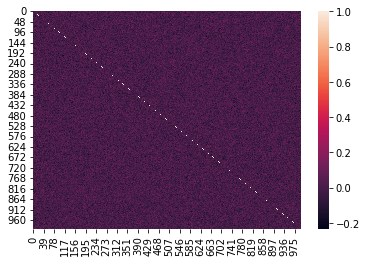

In [33]:
sns.heatmap(cossim)

<AxesSubplot:>

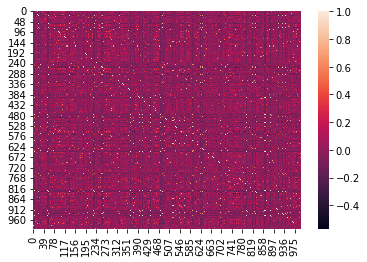

In [34]:
sns.heatmap(cossim_db)

In [46]:
class Student(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.transformer = AutoModel.from_pretrained('../transformers/100000')
        self.centroids = nn.Parameter(torch.rand(1000, 384))

    def forward(self, batch):
        out = self.transformer(**batch)
        out = out.last_hidden_state
        out = out.view(-1, out.size(-1))
        score = torch.mm(out, self.centroids.T)
        return score


In [56]:
teacher = AutoModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [58]:
rand_idx = torch.randint(0, teacher.config.vocab_size, (100, ))

In [63]:
db.size()

torch.Size([1000, 768])

In [62]:
teacher.embeddings.word_embeddings.weight[rand_idx]

torch.Size([100, 768])

In [47]:
s = Student('d')

Some weights of BertModel were not initialized from the model checkpoint at ../transformers/100000 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [55]:
type(w.detach())

torch.Tensor

In [50]:
for name, param in s.named_parameters():
    print(name)

centroids
transformer.embeddings.word_embeddings.weight
transformer.embeddings.position_embeddings.weight
transformer.embeddings.token_type_embeddings.weight
transformer.embeddings.LayerNorm.weight
transformer.embeddings.LayerNorm.bias
transformer.encoder.layer.0.attention.self.query.weight
transformer.encoder.layer.0.attention.self.query.bias
transformer.encoder.layer.0.attention.self.key.weight
transformer.encoder.layer.0.attention.self.key.bias
transformer.encoder.layer.0.attention.self.value.weight
transformer.encoder.layer.0.attention.self.value.bias
transformer.encoder.layer.0.attention.output.dense.weight
transformer.encoder.layer.0.attention.output.dense.bias
transformer.encoder.layer.0.attention.output.LayerNorm.weight
transformer.encoder.layer.0.attention.output.LayerNorm.bias
transformer.encoder.layer.0.intermediate.dense.weight
transformer.encoder.layer.0.intermediate.dense.bias
transformer.encoder.layer.0.output.dense.weight
transformer.encoder.layer.0.output.dense.bias
tr

In [35]:
student = AutoModel.from_pretrained('../transformers/100000')

Some weights of BertModel were not initialized from the model checkpoint at ../transformers/100000 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
centroids = nn.Parameter(torch.rand(1000, 384))

In [39]:
x = torch.randint(0, 10000, (1, 36))

In [41]:
out = student(x)

In [43]:
hs = out.last_hidden_state

In [45]:
hs@centroids.T

torch.Size([1, 36, 1000])

## 3. Index

In [7]:
index = faiss.read_index('../kmeans')

In [29]:
attn_t  = attention(db, db, 24)

In [32]:
kl_div_loss(attn_s, attn_t, 1)

tensor(2.0974e-06, grad_fn=<MulBackward0>)

In [8]:
db = [index.reconstruct(i) for i in range(1000)]
db = np.stack(db, axis=0)
db = torch.tensor(db)
cossim_db = F.cosine_similarity(db.unsqueeze(1), db.unsqueeze(0), dim=-1)

In [12]:
F.l1_loss(cossim, cossim_db)

tensor(0.0937)